# Predicting Insurance Costs

## Introduction

In this project, we'll be looking at the [Medical Cost Data Set](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) from Kaggle. This dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it.

For our regression problem, we're interested in how these different characteristics relate to the total medical cost. It's a continuous, positive number, which makes it a good candidate for a linear regression. For this project, we want to construct the best possible predictive model for the cost, given some information about the patient. Predicting medical costs is an important task because it allows hospitals to predict revenue and plan necessary procedures needed by its patient population.

Let's import the libraries we'll be using, as well as the data and have a quick look:

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

insurance = pd.read_csv("C:/DATABASES/insurance.csv")
insurance.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


array([[<Axes: title={'center': 'charges'}>]], dtype=object)

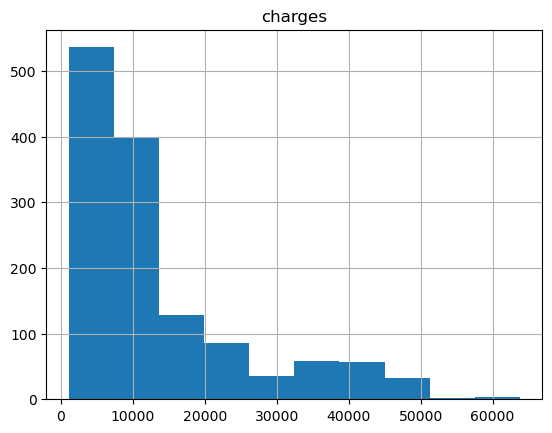

In [7]:
insurance.hist("charges")

The charges column is highly skewed to the right. Extremely costly insurance charges are more common than extremely small ones. This makes it unlikely that the errors in the model will truly be centered at zero. It might be worth it to log-transform the outcome.

array([[<Axes: title={'center': 'log_charges'}>]], dtype=object)

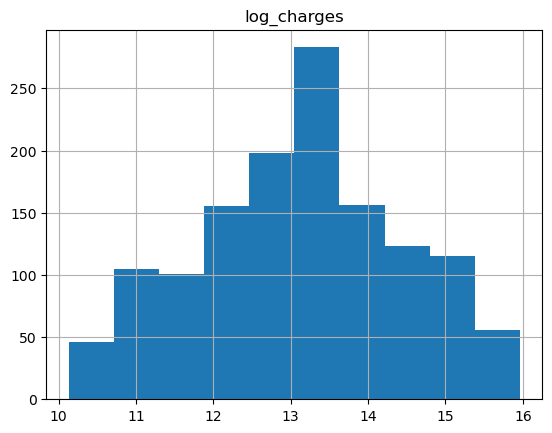

In [8]:
insurance["log_charges"] = np.log2(insurance["charges"])

insurance.hist("log_charges")

## Exploring the Data

In this part, we will first get dummy variables for our categorical columns. We'll then create a heatmap of correlations. Our goal here is to decide on the features that we'll use in our linear regression model.

In [9]:
# getting dummy variables
insurance_dummies = insurance.copy()
insurance_dummies = pd.get_dummies(data=insurance_dummies, columns=["sex", "smoker", "region"], drop_first=True)

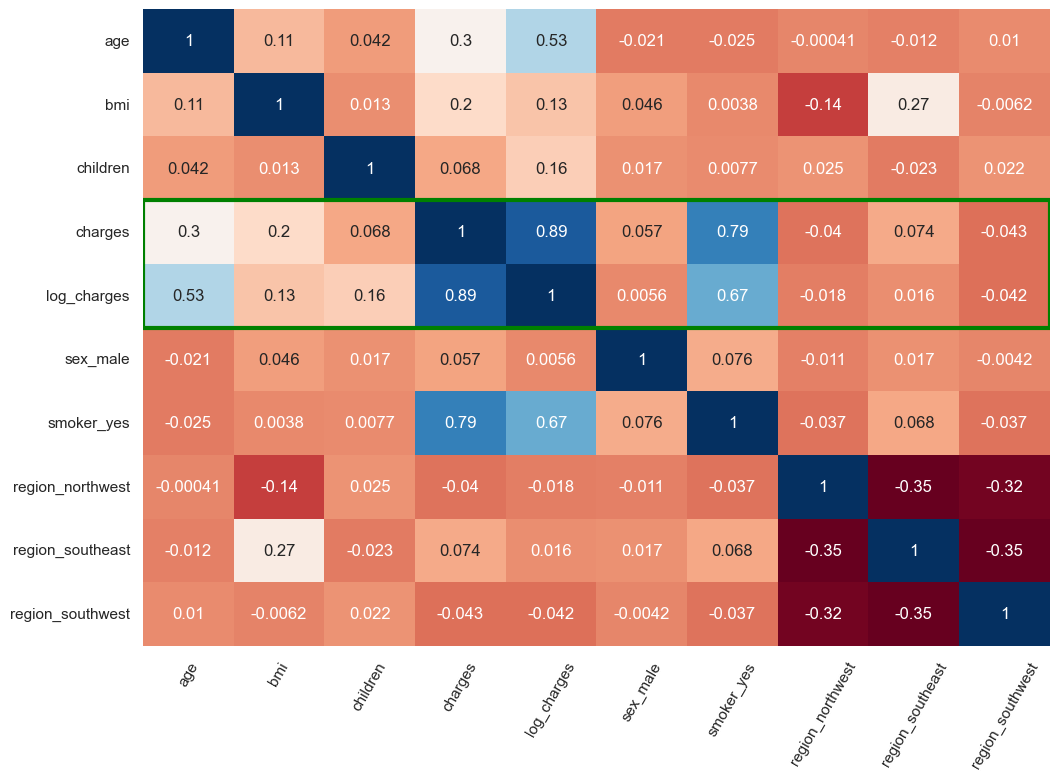

In [10]:
# plotting the heatmap of correlations
from matplotlib.patches import Rectangle
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(insurance_dummies.corr(numeric_only=True),cbar=False,cmap='RdBu',annot=True)
ax.add_patch(Rectangle((0, 3), 10, 2, fill=False, edgecolor='green', lw=3))
plt.xticks(rotation=60)
plt.show()

From our heatmap, we can see that age, bmi and smoker_yes are the columns with the highest correlation with charges. So, we'll be using these three as our features moving forward.

## Dividing The Data

Before we can build the model, we need to divide the insurance dataset into two portions:
- A training set that will be used to estimate the regression coefficients
- A test set that will be used to assess the predictive ability of the model

We need a training set in order to estimate the regression coefficients for each of the predictors in the model. It's crucial that the test dataset is not used to estimate the coefficients because it's supposed to represent new data on which to make predictions. The model is not fit to this data, so the prediction error here helps us understand how the model can be generalized.

We'll be using 80% of the data for training and we'll keep 20% as the test group.

In [11]:
# keeping only the features we decided on
X = insurance_dummies[["age", "bmi", "smoker_yes"]]
y = insurance_dummies["log_charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 10)

## Building The Model

Now that we divided our data, we can start building our model.

In [12]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [13]:
train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, train_pred)
train_mse

0.42469350434776104

In [14]:
R2 = r2_score(y_train, train_pred)
R2

0.7609237670895775

Our mean squared error is 0.42 and the R2 score is 0.76. That is, our model can explain 76% of the variation in the log-insurance charges. But these are optimistic values and we should investigate the model further.

## Residual Diagnostics

In this part, we'll calculate the fitted values for all of the data in the training set and use these calculated values to calculate the residuals of the model. The goal here is to check how well the assumptions of linear regression are met.

Then, we'll plot the residuals against the fitted values on a graph to see if they center around 0 in a band.

<Axes: xlabel='fitted', ylabel='residuals'>

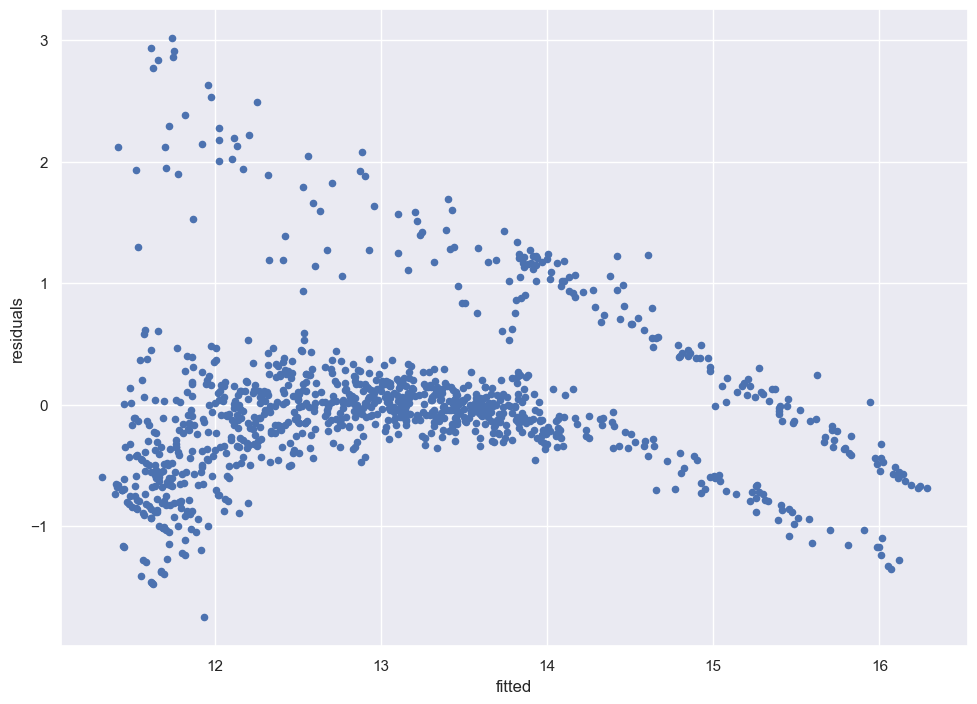

In [15]:
check = pd.DataFrame()
check["residuals"] = y_train - train_pred
check["fitted"] = train_pred

check.plot.scatter(x = "fitted", y = "residuals")

We were expecting an even band around 0 but our residuals don't seem to follow such a trend. This brings into question our assumptions of linear regression in the data. However, our model is far from being useless despite the trend of the residuals.

## Interpreting The Model

In [16]:
# Getting the non-intercept coefficients
model.coef_

array([0.05145774, 0.0164679 , 2.2485029 ])

- A year increase in the subject is associated with a 0.05 increase in the log charges, holding smoking status and bmi constant. About a 5% increase in the charges on the regular scale.
- A unit increase in the subject BMI is associated with a 0.01 increase in the log charges, holding smoking status and age constant. About a 1.6% increase in the charges on the regular scale.
- A smoker is associated with a 2.24 increase in the log charges, holding age and bmi constant. About a 930% increase in the charges on the regular scale.

Note: We are interested in the linear model as a predictive model, not as an inferential model. So, we have no way of knowing if the relationship is statistically significant.

## Final Model Evaluation

It's time to see how the model performs on the test data, which represents a set of new observations that it hasn't been trained on. Predictions should be accurate on any new observations if we want to use it in the new world.

In [17]:
test_pred = model.predict(X_test)
mean_squared_error(y_test, test_pred)

0.5483073263810897

In [18]:
np.exp(mean_squared_error(y_test, test_pred))

1.7303216678184972

In [21]:
R2 = r2_score(y_test, test_pred)
R2

0.6739293200027698

The test MSE and the training MSE are close to each other, which means that our model is not suffering from overfitting. The residuals suggest that the model is predicting much lower costs for subjects who were actually charged much higher. So, our model struggles with these higher costs.

**Thanks for reading!**